In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from utils import lowpass, welch

### **Memories**
 1. Ah, that time when my M&M implementation used negative of the error function XD It worked extremely well for breaking correct initial sync into terrible mess.

### **Tooling!** 
What I want to do here:
  - [x] bit sequence on input
  - [x] map bits to symbols -> gotta plot IQ signal real & imaginary (allow window choice)
  - [x] pulse shaping -> gotta plot the result together with input bits
  - [ ] BPSK modulation + optional frequency, phase offset, white noise -> plot spectrum (notice SNR)
  - [ ] BPSK demodulation - obtain back the IQ signal (Costas loop here?) (plot it again, with loop and without) (plot phase & frequency estimate from Costas loop)
  - [x] M&M timing recovery -> plot input signal together with sample locations (allow window choice), animate constellation
  - [ ] finally map samples to symbols and back to input bits 
    

In [264]:
def animate_constellation(signal, step_size):
    from matplotlib.animation import FuncAnimation

    fig, ax = plt.subplots()
    xdata, ydata = [], []
    ln, = ax.plot([], [], '.')
    
    def init():
        eps_x = 0.05 * (max(np.real(signal)) - min(np.real(signal)))
        eps_y = 0.05 * (max(np.imag(signal)) - min(np.imag(signal)))
        ax.set_xlim(min(-1, min(np.real(signal)) - eps_x), max(1, max(np.real(signal))) + eps_x)
        ax.set_ylim(min(-1, min(np.imag(signal)) - eps_y), max(1, max(np.imag(signal))) + eps_y)
        return ln,

    def update(frame):
        ln.set_data(np.real(frame), np.imag(frame))
        return ln,
    
    frames = [signal[i:i + step_size] for i in range(0, len(signal) - step_size, step_size)]
    return FuncAnimation(fig, update, frames=frames, init_func=init, blit=True)


def animation_to_html5_video(animation):
    HTML(animation.to_html5_video())

    
def plot_signals(signals, start=0, width=None, figsize=(20, 10), normalize=True):
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize)
    for s in signals:
        n_s = s / max(s) if normalize else s
        ax.plot(n_s[start:-1 if width is None else start + width])


def plot_real_imag(complex_signal, start=0, width=None):
    plot_signals([np.real(complex_signal), np.imag(complex_signal)], start, width)


def to_bpsk_signal(bits, carrier_freq, pulse, f_sampling, phase_offset=0, freq_offset=0):
    # oversample the signal to obtain symbol pulse sequence
    samples_per_symbol = len(pulse)
    symbol_pulses = np.zeros(len(bits) * samples_per_symbol)
    symbol_pulses[::samples_per_symbol] = to_bpsk_symbols(bits)
    
    # convolve the pulse train with pulse shape
    pulse_shaped = np.convolve(pulse, symbol_pulses, mode='same')
    
    t_s = np.linspace(0, len(pulse_shaped) / f_sampling, len(pulse_shaped))
    return np.real(pulse_shaped * np.exp(2 * np.pi * (carrier_freq + freq_offset) * t_s + phase_offset))


def text_to_utf8_bits(text, bits_length=None):
    return np.unpackbits(np.frombuffer(text.encode('utf-8'), dtype=np.uint8))


def to_bpsk_symbols(bits):
    return np.exp(np.pi * bits * 1j)


def symbols_to_pulse_train(symbols, sps):
    result = np.zeros(len(symbols) * sps, dtype='complex')
    result[::sps] = symbols
    return result


def to_iq_signal(input_signal, t_s, f_carrier, f_symbol, f_sampling, lp_offset=5000):
    i_signal_pre_lpf = input_signal * np.cos(2 * np.pi * f_carrier * t_s)
    q_signal_pre_lpf = input_signal * np.sin(2 * np.pi * f_carrier * t_s)
    i_signal = lowpass(i_signal_pre_lpf, f_sampling, f_symbol + lp_offset)
    q_signal = lowpass(q_signal_pre_lpf, f_sampling, f_symbol + lp_offset)
    return i_signal + 1j * q_signal


def mm_recover_symbols(signal, to_symbol, samples_per_symbol, alpha=0.3):
    # steps:
    #  - sample the signal using estimated delta_t
    #  - update delta_t
    sample_indexes = [0]
    samples = [signal[0]]
    symbols = [to_symbol(samples[0])]
    deltas = []
    i, delta_t = 1, 0
    
    while i < len(signal):
        sample_indexes.append(i)
        samples.append(signal[i])
        symbols.append(to_symbol(signal[i]))
        
        mm_delta = np.real(samples[-2] * np.conj(symbols[-1]) - samples[-1] * np.conj(symbols[-2]))
        delta_t += samples_per_symbol + alpha * mm_delta
        deltas.append(delta_t)
        
        i += int(delta_t)
        delta_t -= int(delta_t)
    
    return np.array(sample_indexes[1:]), np.array(symbols[1:]), np.array(deltas)


def to_bpsk_symbol(sample):
    return 2 * int(np.real(sample) < 0) - 1 + 1j * 0  # return 0 for phase ~= 0 and 1 for phase ~= PI


def plot_time_sync_results(input_signal, t_s, symbol_indexes, samples_per_symbol, start=0, width=None, figsize=(20,10)):
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize)

    end = start + width if width is not None else len(input_signal)
    
    ax.plot(
        t_s[symbol_indexes][start // samples_per_symbol:end // samples_per_symbol], 
        np.real(input_signal[symbol_indexes])[start // samples_per_symbol:end // samples_per_symbol], 
        '*', 
        label='symbols'
    )
    ax.plot(t_s[start:end], np.real(input_signal[start:end]), label='I')
    ax.plot(t_s[start:end], np.imag(input_signal[start:end]), label='Q')
    ax.legend()

### **BPSK**

In [4]:
T_total = 1  # seconds
f_carrier = 57000  # Hertz (RDS carrier frequency)
f_symbol = f_carrier / 48  # 1187.5 Hz (RDS symbol frequency)
f_sampling = 171000  # gotta be > 2 * f_carrier

N = T_total * f_sampling
t_s = np.linspace(0, 1, N)
samples_per_symbol = int(f_sampling / f_symbol)

In [7]:
message = """No siema, witajcie w mojej kuchni. Dzisiaj ugotujemy coś RDSowego."""
message_bits = np.unpackbits(np.frombuffer(message.encode('utf-8'), dtype=np.uint8))
message_signal = np.repeat(message_bits, samples_per_symbol)
message_signal_padded = np.pad(message_signal, (0, N - len(message_signal)), mode='constant')

Bi-phase shift keying approach: $$y_i = sin(2 \pi f t_i + \phi_i), \ \phi_i \in \{ 0, \pi\}$$

Quadrature amplitude modulation approach: $$y_i = m_i sin(2 \pi f t_i), \ m_i \in \{ -1, 1 \}$$

They're both equivalent.

In [6]:
signal_bpsk = np.sin(2 * np.pi * f_carrier * t_s + np.pi * message_signal_padded)

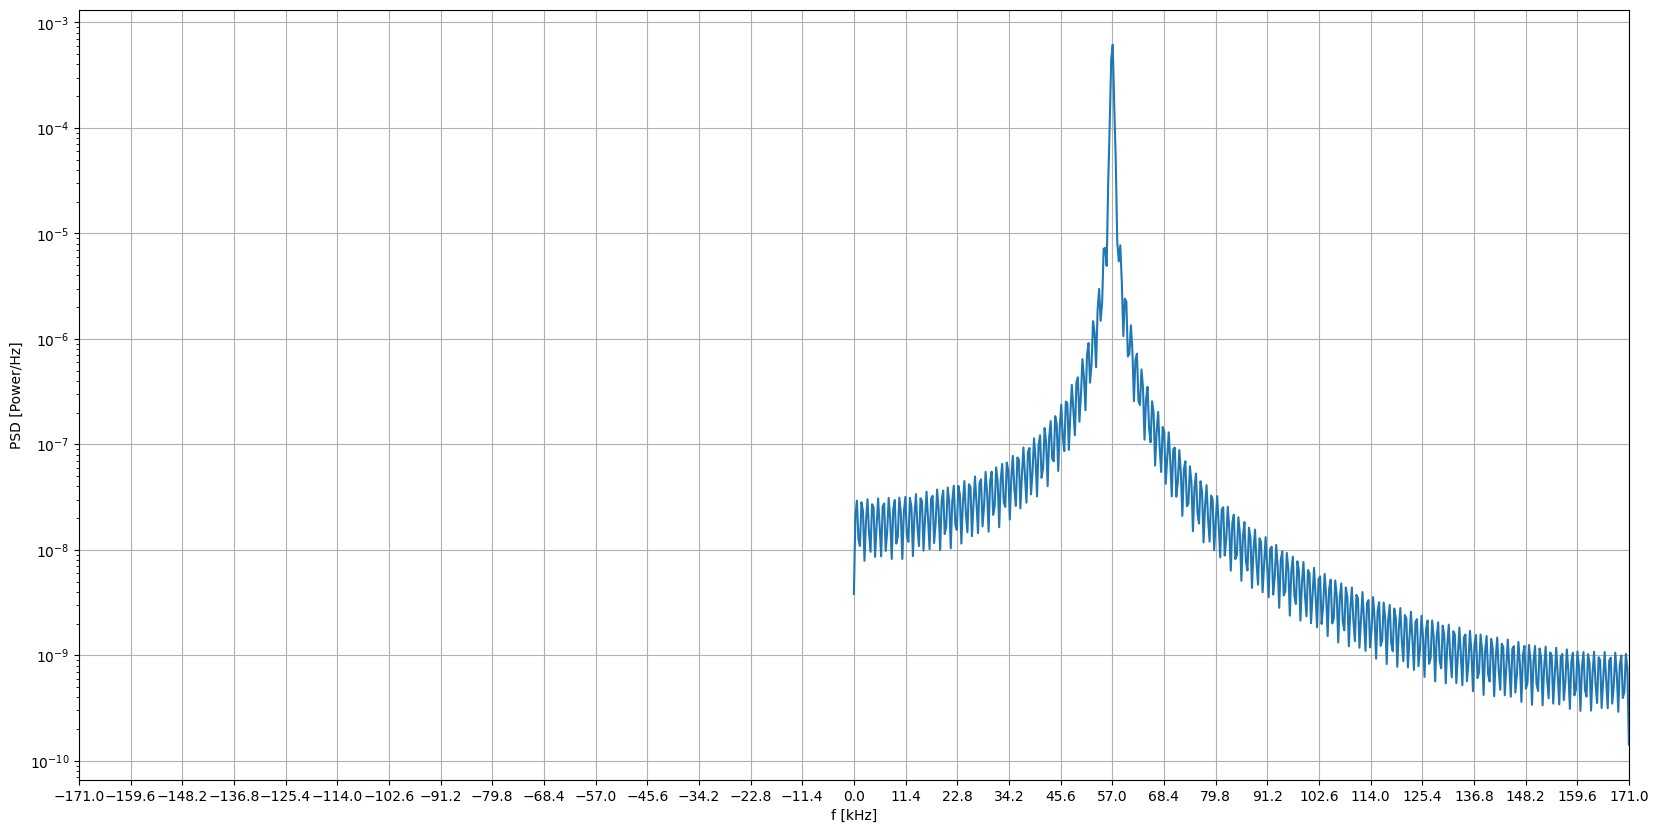

In [7]:
welch(signal_bpsk, f_sampling)

Not plotting time domain signal because there's a lot of samples per single symbol so there's little variation.

In [ ]:
# -1 because we want the samples to be centered around 0
t_max = (samples_per_symbol - 1) / 2 / f_sampling
pulse_shape_ts = np.linspace(-t_max, t_max, samples_per_symbol)

# todo: np.arange(-50, 51) (we just need the shape to decay to zero)
rolloff_factor = 0.5
raised_cosine = 
ps_bpsk = to_bpsk_signal(message_bits, f_carrier, pulse, f_sampling, phase_offset=0, freq_offset=0)

**Demodulation**

Question: do we need higher sampling rate so that we can filter out high-frequency components when producing $I(t)$ and $Q)t)$ signals?

In [8]:
i_signal_pre_lpf = signal_bpsk * np.sin(2 * np.pi * f_carrier * t_s)
q_signal_pre_lpf = signal_bpsk * np.cos(2 * np.pi * f_carrier * t_s)

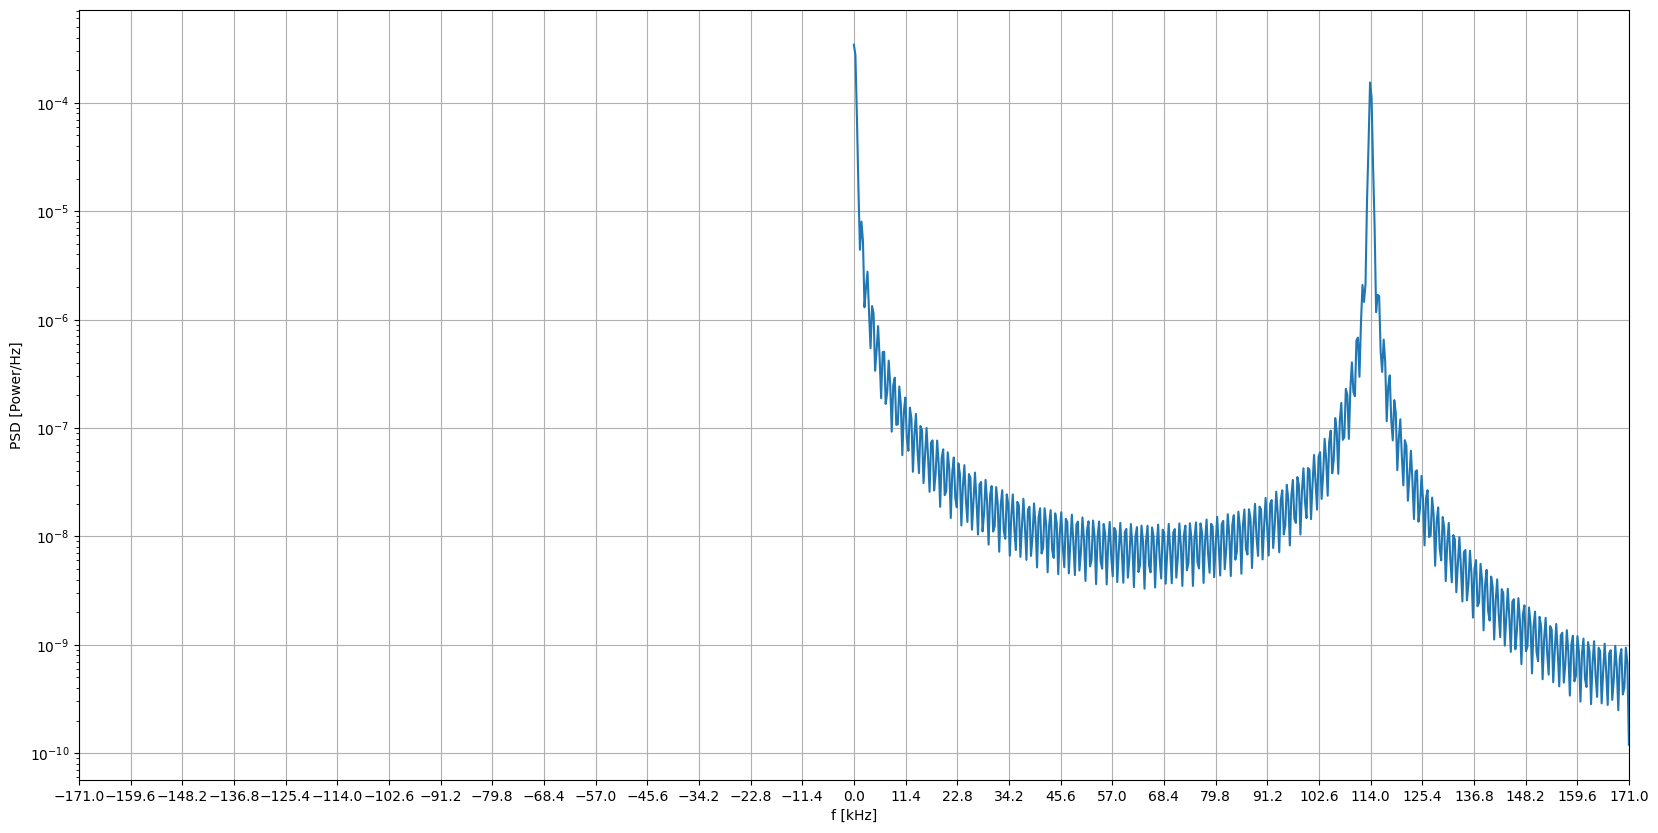

In [9]:
welch(i_signal_pre_lpf, f_sampling)

In [10]:
# 1187.5 Hz is the symbol frequency
i_signal = lowpass(i_signal_pre_lpf, f_sampling, 10000)
q_signal = lowpass(q_signal_pre_lpf, f_sampling, 10000)

Original $I(t)$ signal equals 1 for bit input 0 and equals -1 for bit input 1. Here we have it times 0.5  because sum of cosines.

Original $Q(t)$ signal is 0.

[0 1 0 0 1 1 1 0 0 1]


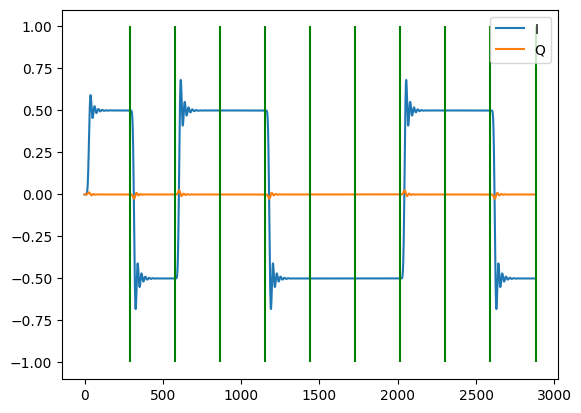

In [11]:
lookup_symbols = 10
print(message_bits[:10])
lookup_samples = int(lookup_symbols * samples_per_symbol)
plt.plot(i_signal[:lookup_samples], label='I')
plt.plot(q_signal[:lookup_samples], label='Q')
plt.legend()
plt.vlines(np.arange(1, lookup_symbols + 1) * samples_per_symbol, -1, 1, color='green');

**Mueller and Muller timing recovery**

Without offset it should just work.

In [13]:
iq_signal = i_signal + 1j * q_signal
indexes, symbols, _ = mm_recover_symbols(iq_signal, to_bpsk_symbol, samples_per_symbol)

/home/kuba/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


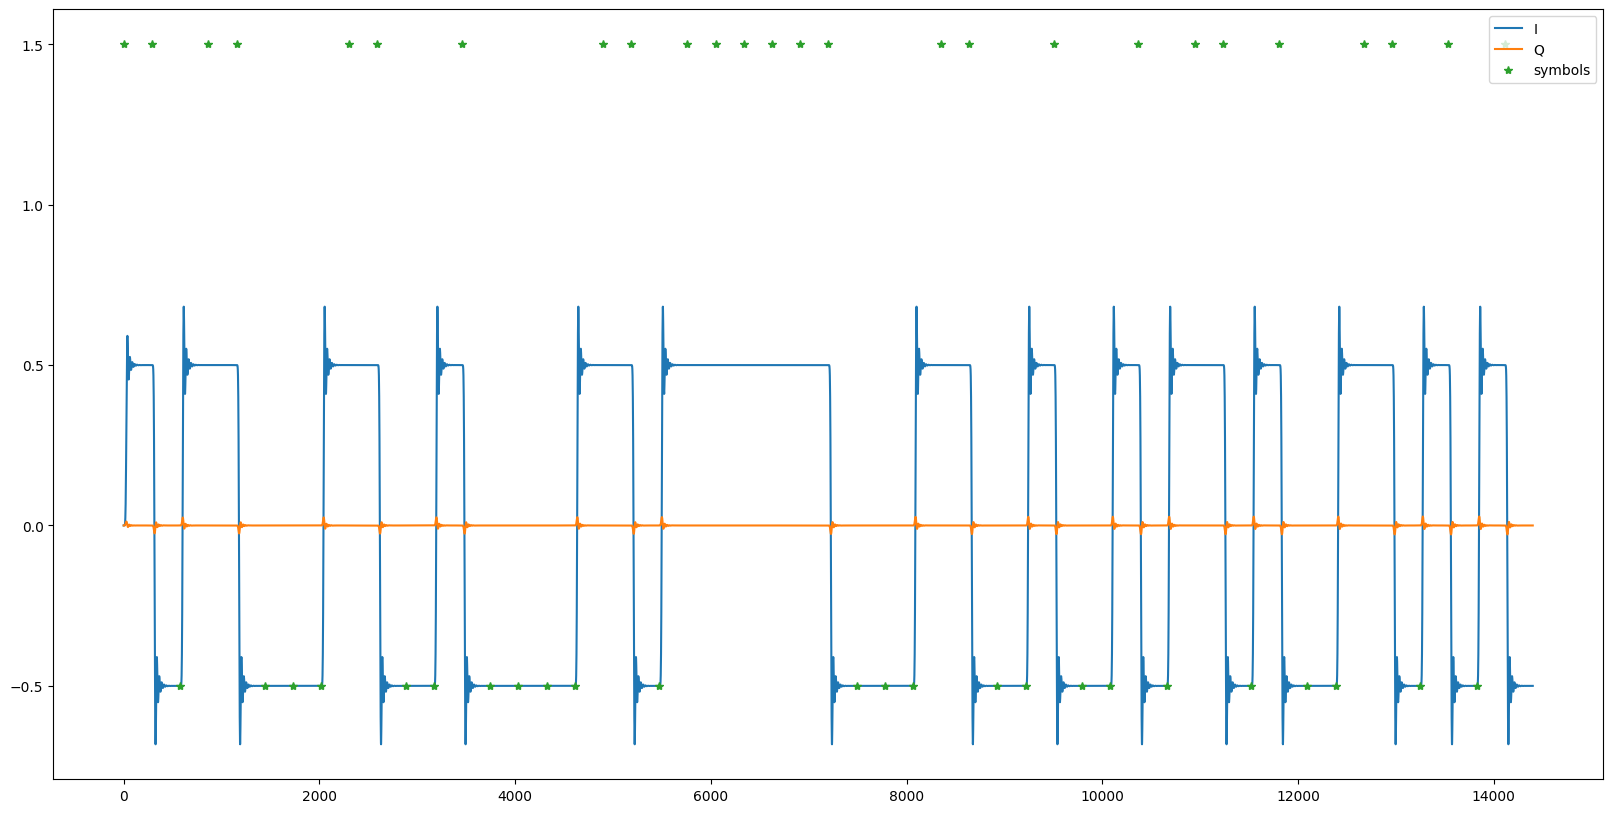

In [14]:
lookup_symbols = 50
lookup_samples = int(lookup_symbols * samples_per_symbol)

plt.figure(figsize=(20, 10))
plt.plot(i_signal[:lookup_samples], label='I')
plt.plot(q_signal[:lookup_samples], label='Q')
plt.plot(indexes[:lookup_symbols], 0.5 - symbols[:lookup_symbols], '*', label='symbols')
plt.legend();

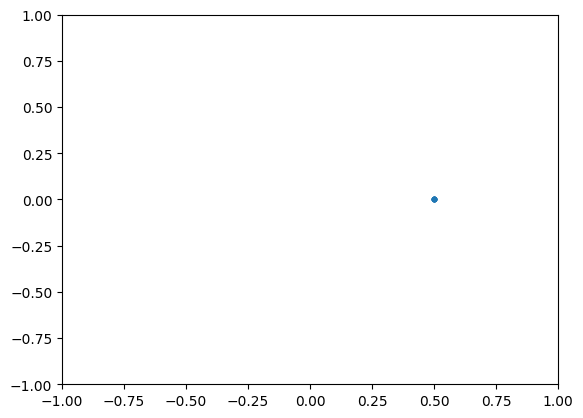

In [15]:
symbol_samples = iq_signal[indexes]
ani = animate_constellation(symbol_samples, 10)


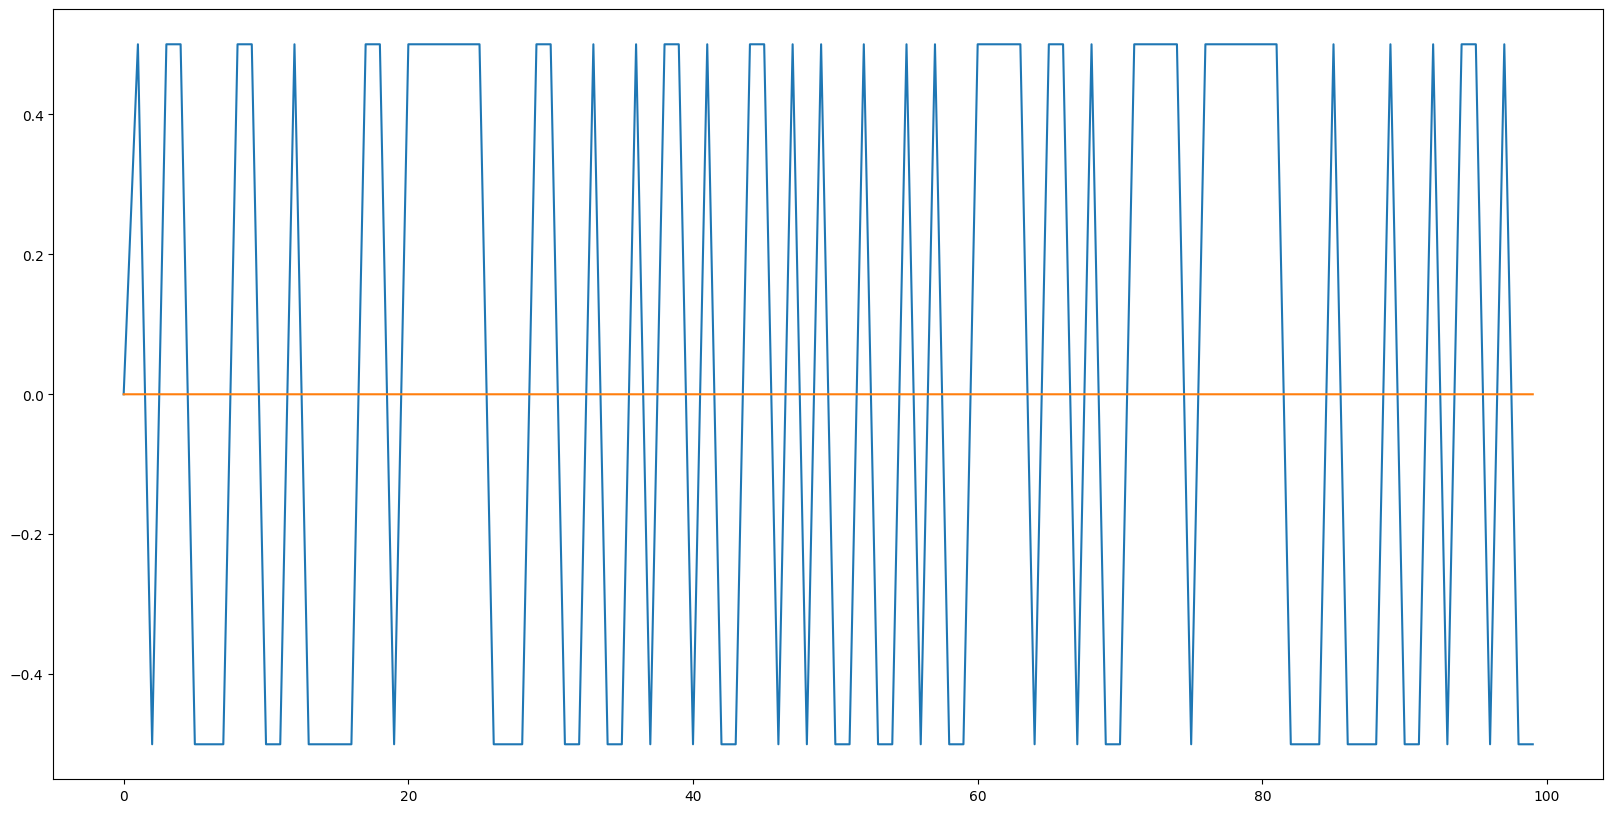

In [23]:
plot_iq(symbol_samples[:100])

**M&M timing recovery with phase and frequency offset**

Phase offset could be applied by convolution with phase-shifted *sinc* function.

In [24]:
f_offset = 10  # PySDR choice
phase_offset = int(0.4 * samples_per_symbol)  # shift by 0.4 of a symbol

signal_bpsk_offset = np.sin(2 * np.pi * (f_carrier + f_offset) * t_s + np.pi * message_signal_padded)[phase_offset:]

In [42]:
iq_offset_signal = mk_iq_signal(signal_bpsk_offset, t_s[phase_offset:], f_carrier, f_symbol, f_sampling)
offset_indexes, _, deltas = mm_recover_symbols(iq_offset_signal, to_bpsk_symbol, samples_per_symbol)
offset_symbol_samples = iq_offset_signal[offset_indexes]

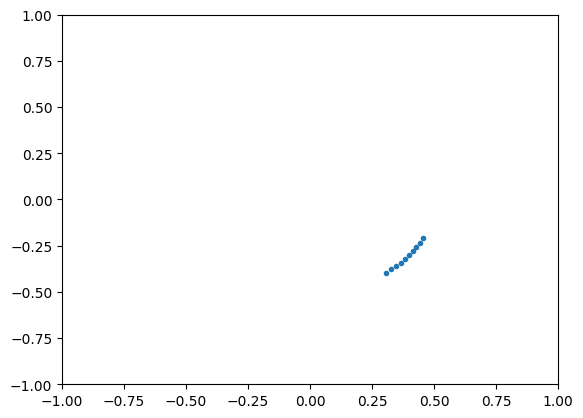

In [29]:
ani2 = animate_constellation(offset_symbol_samples, 10)
HTML(ani2.to_html5_video())

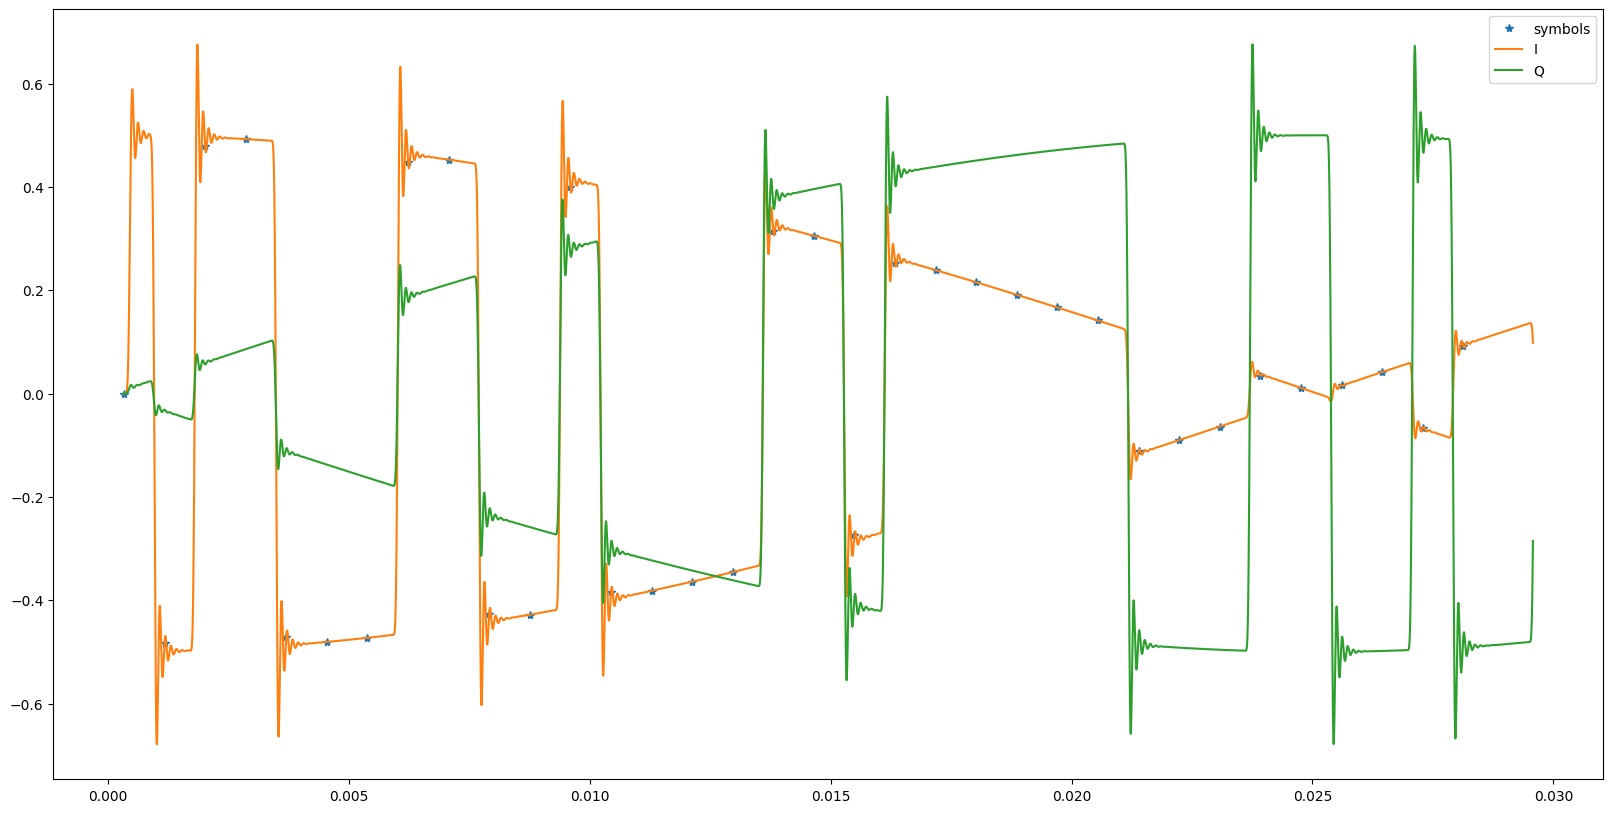

In [65]:
cut = 10000
plt.figure(figsize=(20, 10))
plt.plot(t_s[phase_offset:][offset_indexes][:cut // samples_per_symbol], np.real(iq_offset_signal[offset_indexes])[:cut // samples_per_symbol], '*', label='symbols')
plt.plot(t_s[phase_offset:][:cut], np.real(iq_offset_signal[:cut]), label='I')
plt.plot(t_s[phase_offset:][:cut], np.imag(iq_offset_signal[:cut]), label='Q')
plt.legend();

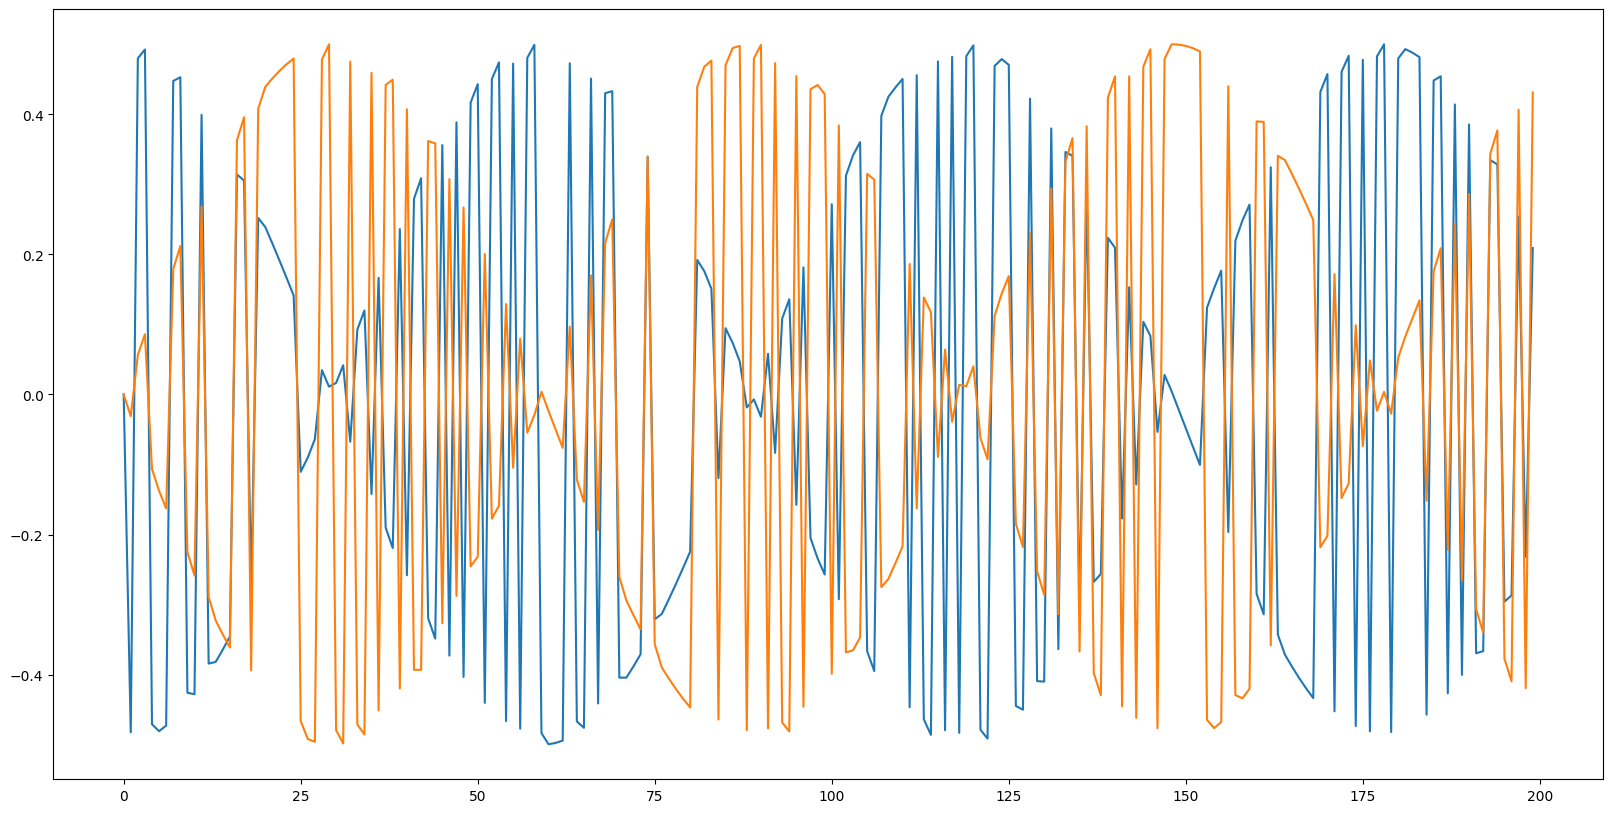

In [30]:
plot_iq(offset_symbol_samples[:200])

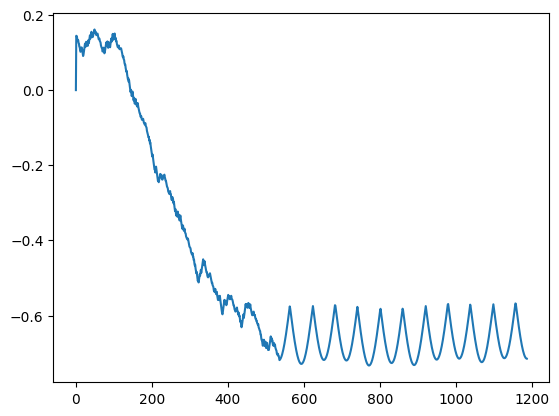

In [33]:
plt.plot(deltas);

I have a theory that deltas do absolutely nothing mainly because I and Q signals are flat (no pulse shaping) so actually wherever we sample it's ok.

### **Message -> BPSK symbol train**

In [5]:
msg = """We have discussed how to transmit digitally over the air, utilizing a digital modulation scheme like QPSK and by applying pulse shaping to limit the signal bandwidth. Channel coding can be used to deal with noisy channels, such as when you have low SNR at the receiver. Filtering out as much as possible before digitally processing the signal always helps. In this chapter we will investigate how synchronization is performed on the receiving end. Synchronization is a set of processing that occurs before demodulation and channel decoding. The overall tx-channel-rx chain is shown below, with the blocks discussed in this chapter highlighted in yellow. (This diagram is not all-encompassing–most systems also include equalization and multiplexing)."""
msg_bits = text_to_utf8_bits(msg)
msg_symbols = to_bpsk_symbols(msg_bits)
msg_pulses = symbols_to_pulse_train(msg_symbols, samples_per_symbol)

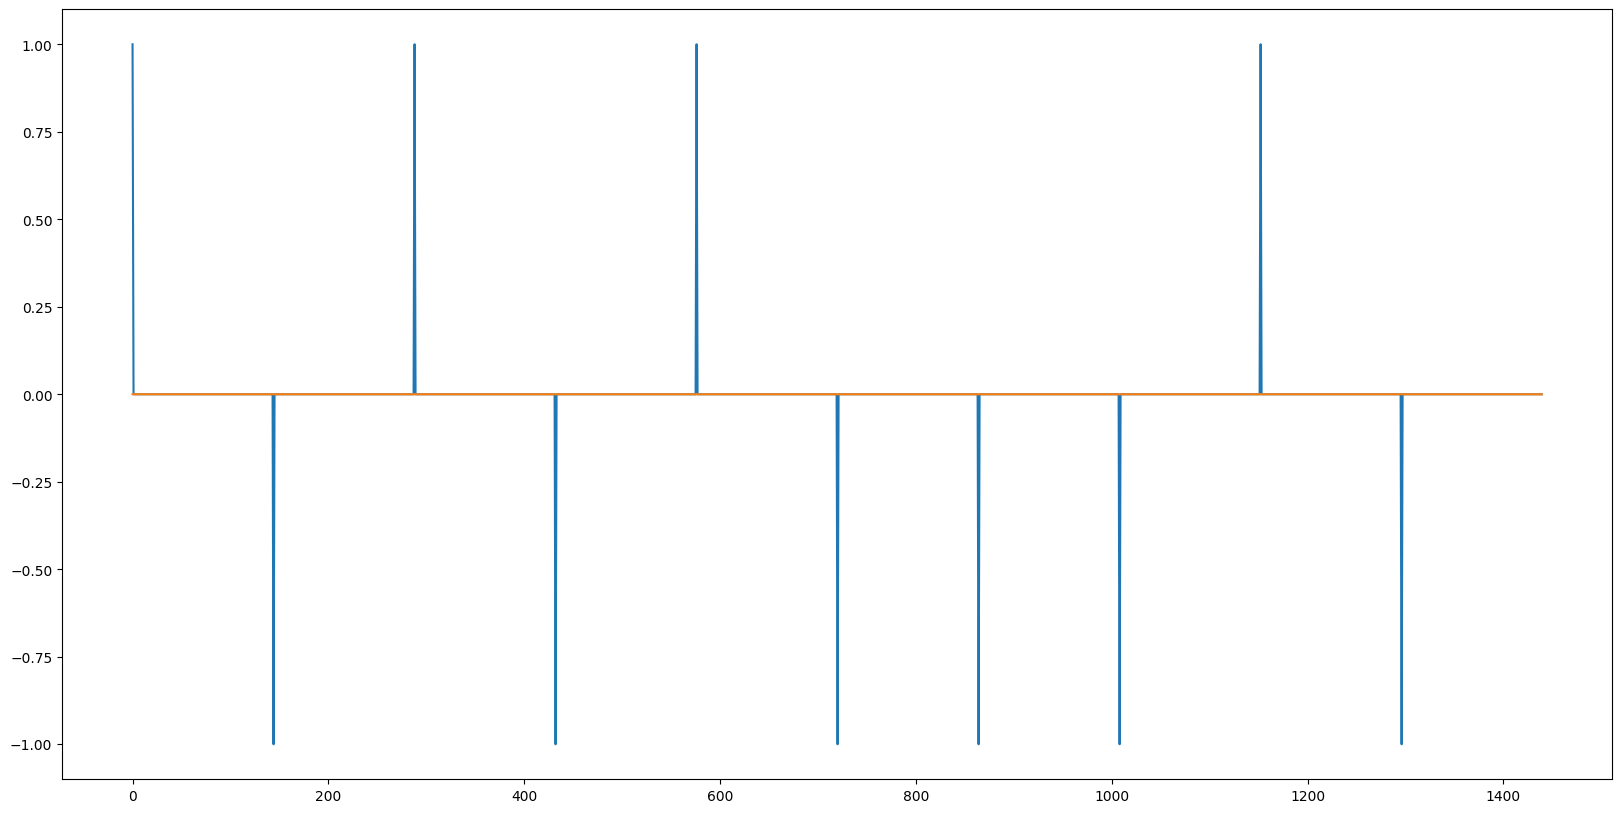

In [6]:
n_peek_symbols = 10
plot_real_imag(msg_pulses, width=n_peek_symbols * samples_per_symbol)

def to_bpsk_signal(bits, carrier_freq, pulse, f_sampling, phase_offset=0, freq_offset=0):
    # oversample the signal to obtain symbol pulse sequence
    samples_per_symbol = len(pulse)
    symbol_pulses = np.zeros(len(bits) * samples_per_symbol)
    symbol_pulses[::samples_per_symbol] = to_bpsk_symbols(bits)
    
    # convolve the pulse train with pulse shape
    pulse_shaped = np.convolve(pulse, symbol_pulses, mode='same')
    
    t_s = np.linspace(0, len(pulse_shaped) / f_sampling, len(pulse_shaped))
    return np.real(pulse_shaped * np.exp(2 * np.pi * (carrier_freq + freq_offset) * t_s + phase_offset))

### **BPSK symbol train pulse shaping**
I don't know how long of a time window I should use for my RRC impulse response - I guess it needs to be long enough to sufficiently roll off to zero on both ends.

**Important:** 
 - I have 144 samples per symbol, PySDR example has 8, so I need 16 times as many samples of RRC impulse response to have the same rolling off shape

**Question:** why on Earth PySDR (and Wikipedia) formula produces values in 1e3 range? Maybe it doesn't matter, we can normalize the produced signal energy?

In [7]:
def rrc_impulse_response(ts, beta, T_s):
    def rrc(t):
        if t == 0:
            return (1 + beta * (4 / np.pi - 1)) / T_s
        elif np.abs(t) == (T_s / (4 * beta)):
            # will we ever hit it? (precision)
            return (beta * ((1 + 2 / np.pi) * np.sin(np.pi / (4 * beta)) + (1 - 2 / np.pi) *np.cos(np.pi / (4 * beta)))) / (T_s * np.sqrt(2))
        else:
            num = np.sin(np.pi * t / T_s * (1 - beta)) + 4 * beta * t  / T_s * np.cos(np.pi * t / T_s * (1 + beta))
            denom = np.pi * t * (1 - (4 * beta * t / T_s) ** 2)
            return num / denom
    
    return np.array([rrc(t) for t in ts])

T_s = 1 / f_symbol
ts = np.arange(-50 * 16 / f_sampling, (50 * 16 + 1) / f_sampling, 1 / f_sampling)
ps_filter = rrc_impulse_response(ts, beta=0.35, T_s=1 / f_symbol) * T_s

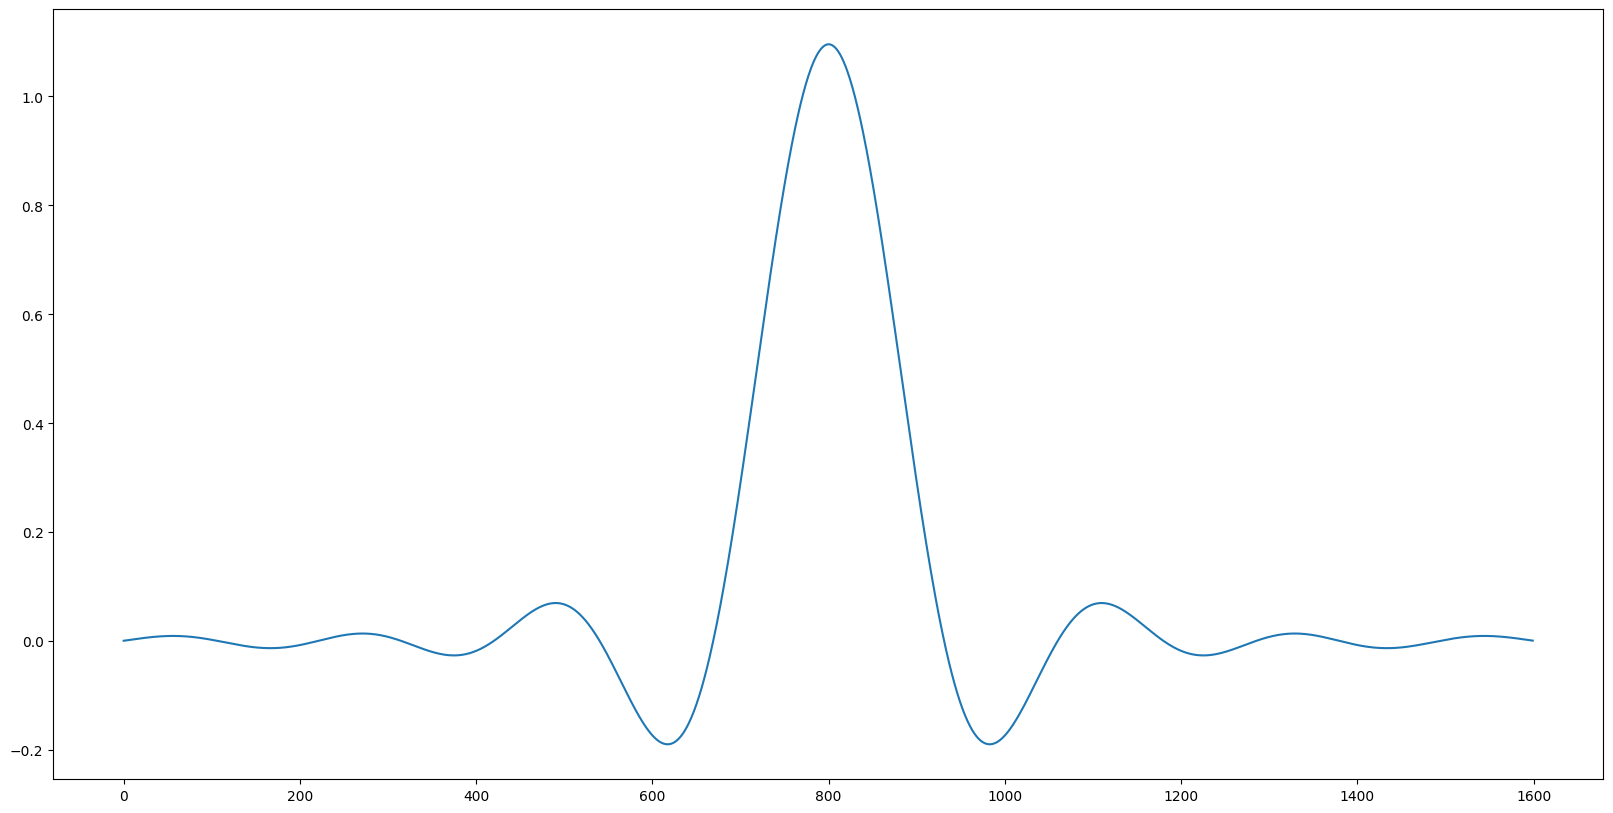

In [8]:
plot_signals([ps_filter])

In [9]:
msg_pulse_shaped = np.convolve(msg_pulses, ps_filter, mode='same')
msg_pulse_shaped_received = np.convolve(msg_pulse_shaped, ps_filter, mode='same')

/home/kuba/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


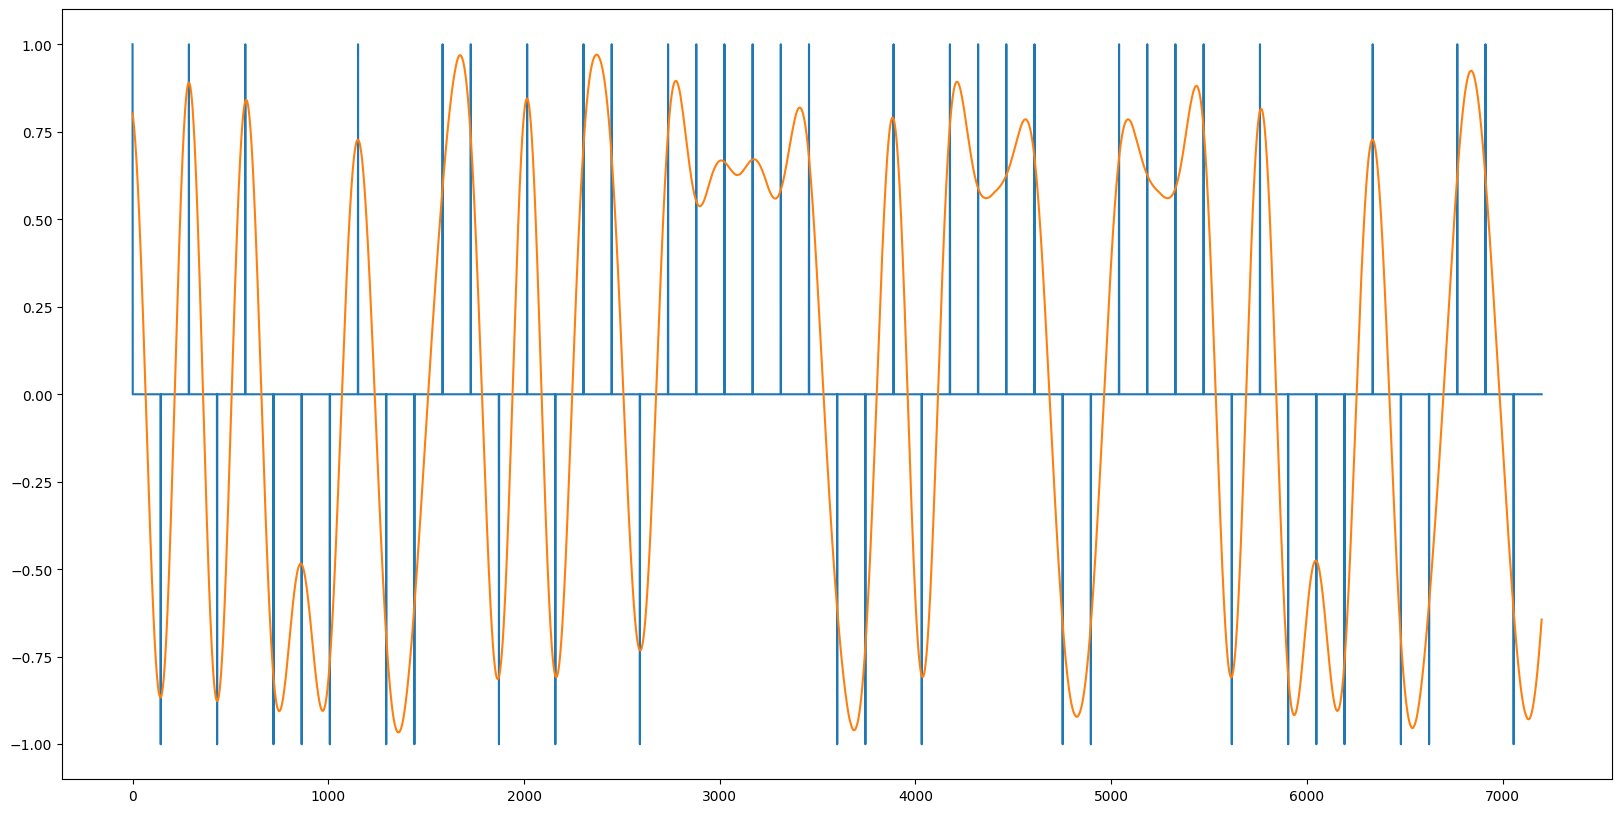

In [10]:
plot_signals([msg_pulses, msg_pulse_shaped / max(msg_pulse_shaped)], width=50 * samples_per_symbol)

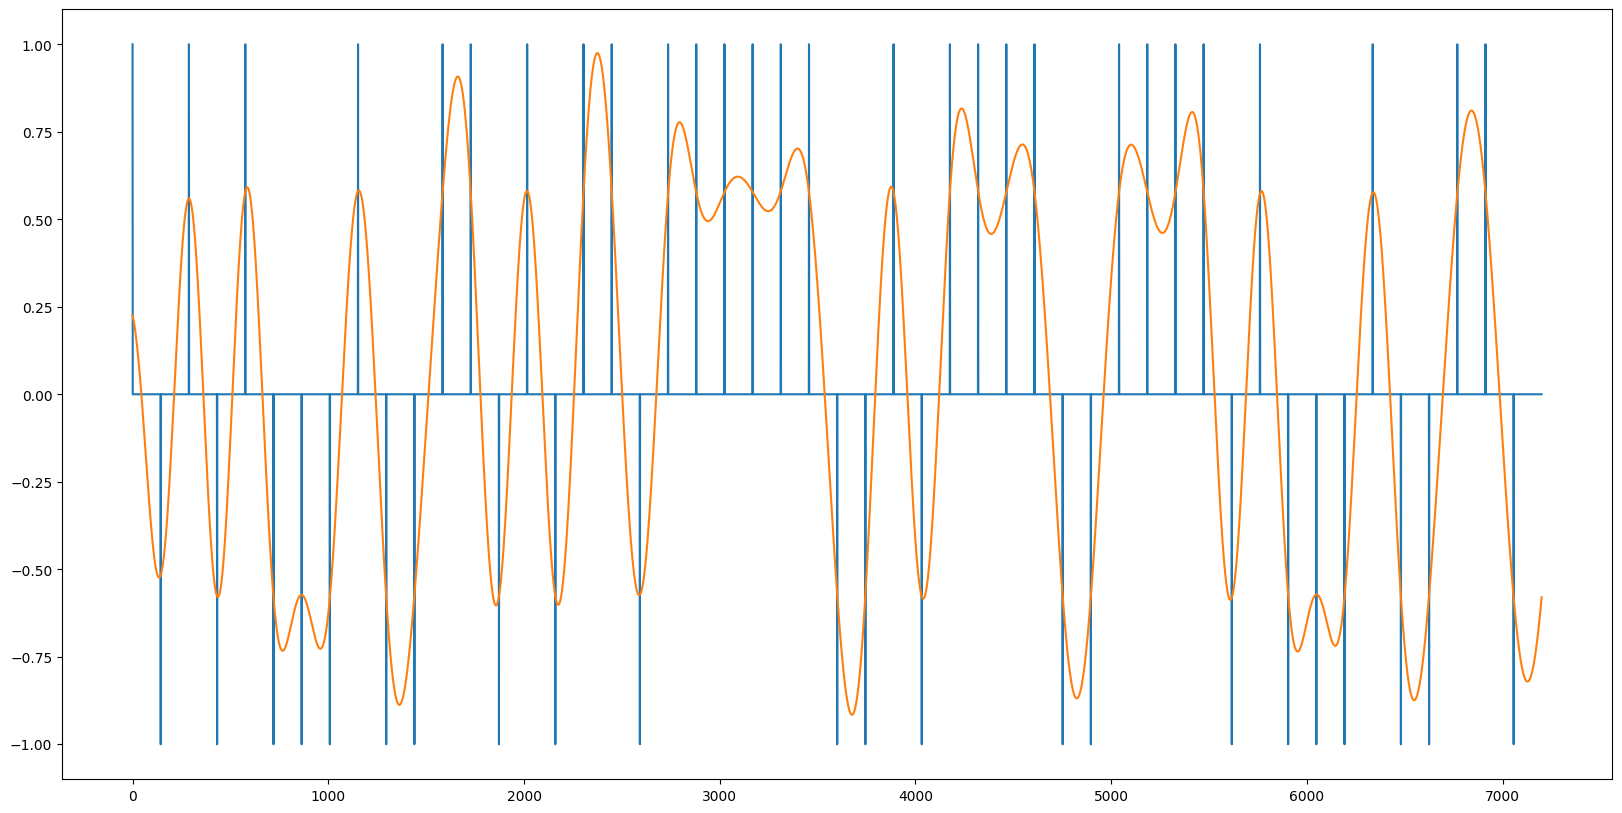

In [11]:
plot_signals([
        msg_pulses,
        msg_pulse_shaped_received / max(msg_pulse_shaped_received)
    ], 
    width=50 * samples_per_symbol
)

We can see slight ISI before applying matched filter.

### **M&M timing recovery applied to pulse-shaped signal**

**TODO:**
 - [x] take pulse shaped signal (it's a quadrature signal, i.e. sequence of I/Q samples) and use it to modulate carrier signal (multiply by complex sinusoid and take the real part)
   - (optionally) introduce carrier signal frequency and phase offset
 - [ ] (optionally) apply noise to "transmitted" signal
 - [ ] apply matched filter to "received" signal
 - [ ] produce I/Q samples by mixing with sinusoid produced by received oscillator (offsets unknown)
   - [ ] use Costas loop here to obtain I/Q samples
 - [ ] apply M & M recovery technique

Thinking... I don't see why carrier signal isn't a pretty sinusoid, it looks like aliasing is involved???

In [308]:
T = len(msg_pulse_shaped) / f_sampling
phase_offset = 0.5 * 2 * np.pi
frequency_offset = 0  # 10Hz for now, for 13kHz coarse frequency sync methods are required?
t_s = np.arange(0, len(msg_pulse_shaped) / f_sampling, 1 / f_sampling)
carrier_signal = np.exp((2 * np.pi * (f_carrier + frequency_offset) * t_s + phase_offset) * 1j)
transmitted_signal = np.real(msg_pulse_shaped * carrier_signal)

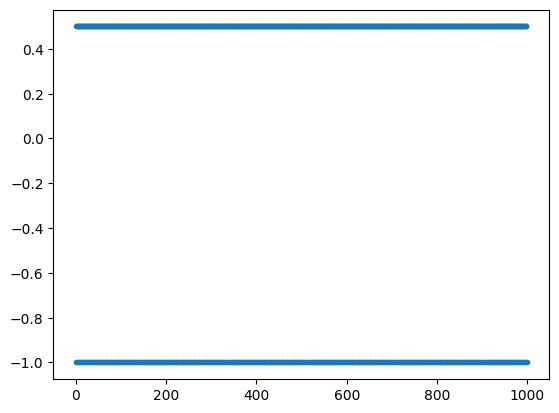

In [309]:
plt.plot(np.real(carrier_signal)[:1000], '.')

/home/kuba/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


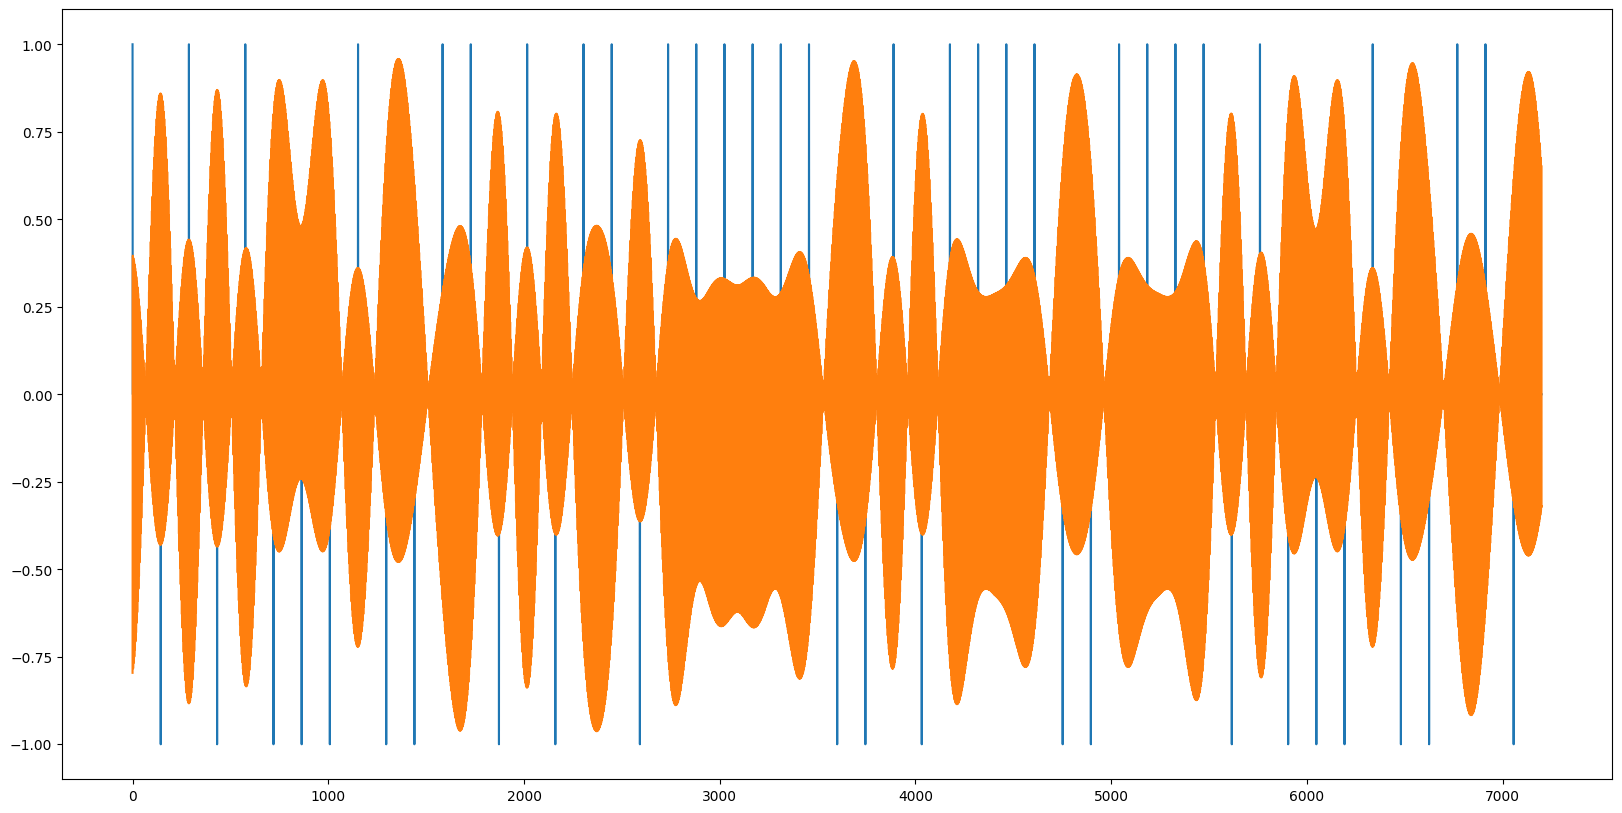

In [310]:
plot_signals([2 * msg_pulses, transmitted_signal], width=50 * samples_per_symbol)

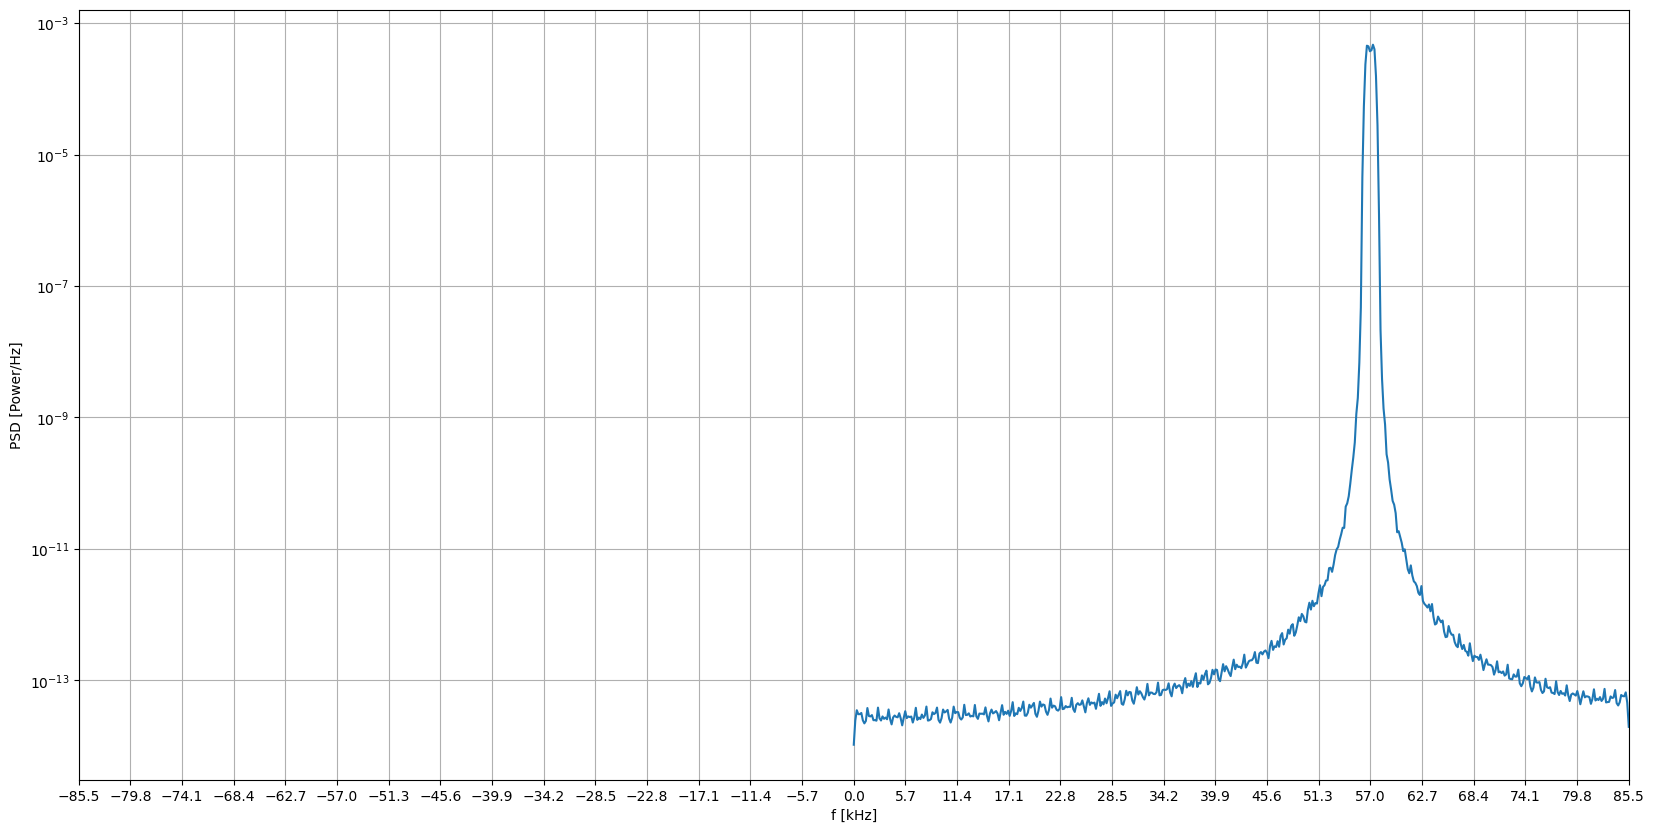

In [311]:
welch(transmitted_signal, f_sampling)

Okay, this signal looks WEIRD to me. But the spectrum looks just like what I remember received (2 little spikes on both sides of 57kHz) and also, this is not the transmitted signal. It's what we'd use to (in turn) frequency-modulate the real MHz carrier. Perhaps this is just what using pulse-shaped signal for QAM looks like?

Okay, but for real this is just carrier sinusoid multiplied (AM really) by our `msg_pulse_shaped` above - so this is just fine.

In [312]:
received_iq_signal = to_iq_signal(transmitted_signal, t_s, f_carrier, f_symbol, f_sampling, lp_offset=1000)

In [313]:
received_iq_signal_filtered = np.convolve(received_iq_signal, ps_filter.astype('complex'), mode='same')

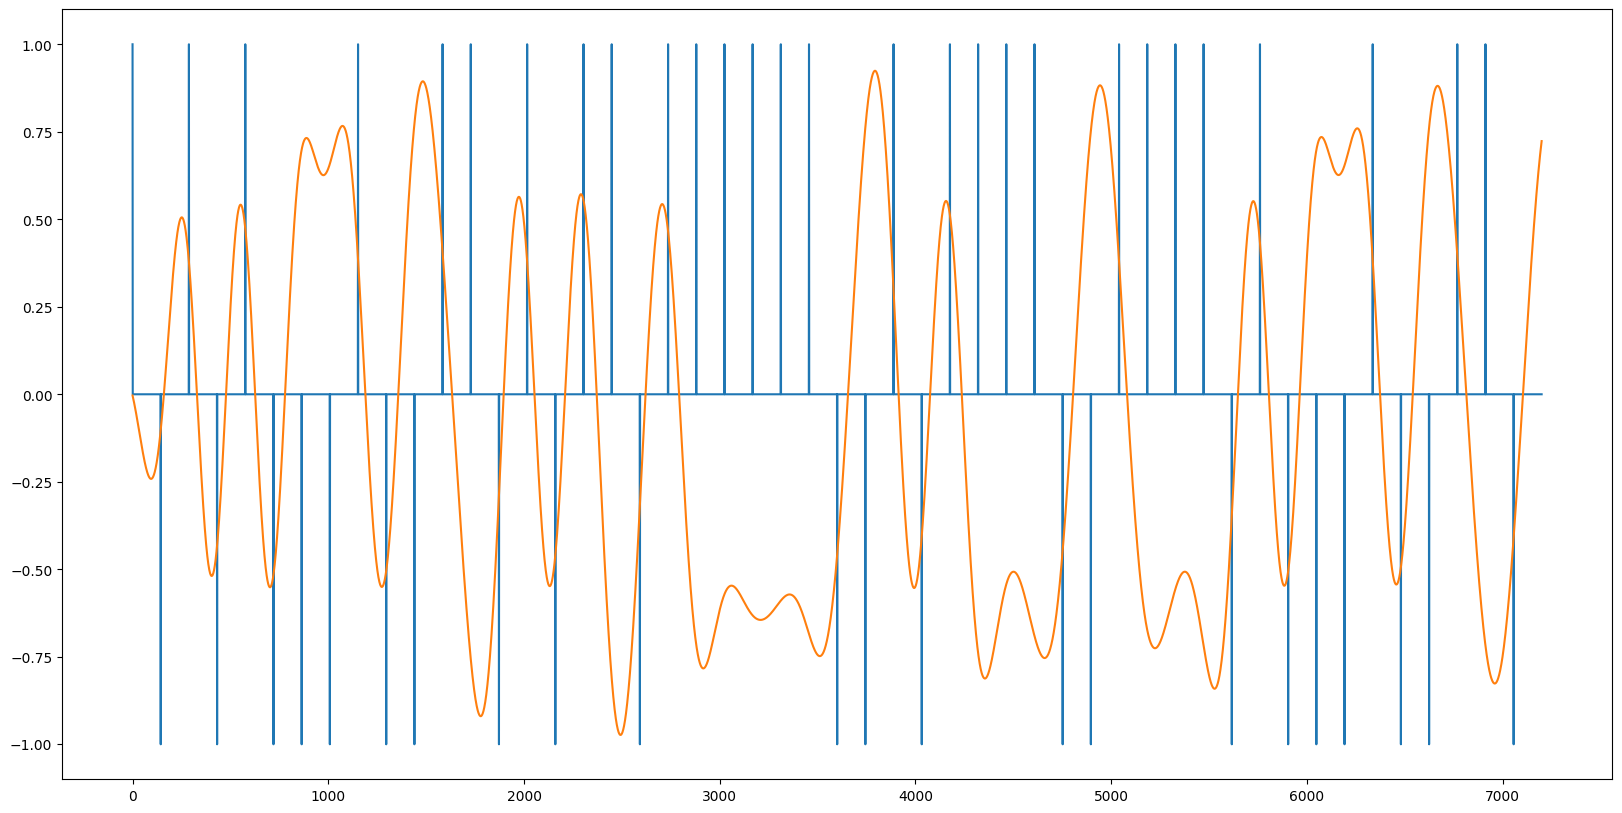

In [314]:
plot_signals([msg_pulses, received_iq_signal_filtered], width=50 * samples_per_symbol)

In [324]:
indexes, symbols, deltas = mm_recover_symbols(received_iq_signal_filtered, to_bpsk_symbol, samples_per_symbol, alpha=0.005)

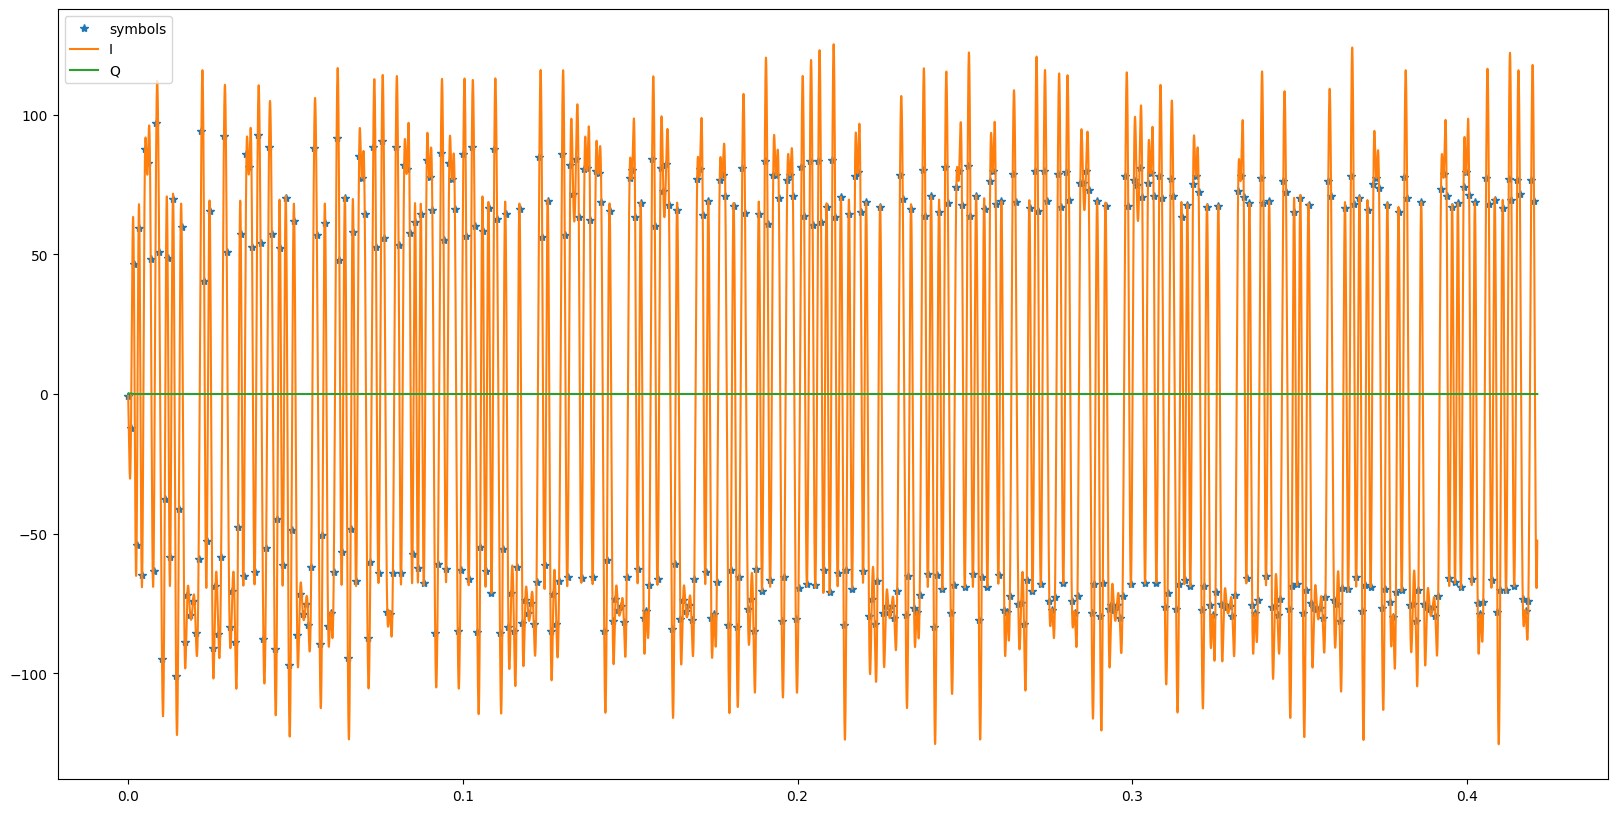

In [325]:
plot_time_sync_results(received_iq_signal_filtered, t_s, indexes, samples_per_symbol, start=0 * samples_per_symbol, width=500 * samples_per_symbol)

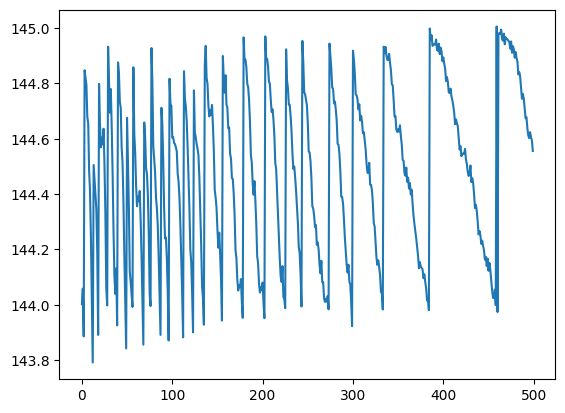

In [326]:
plt.plot(deltas[:500])

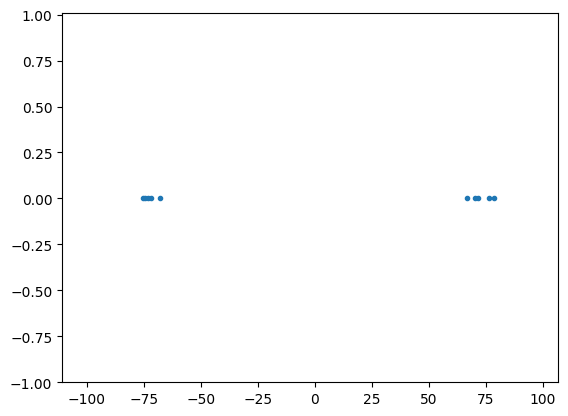

In [327]:
ani2 = animate_constellation(received_iq_signal_filtered[indexes], 10)
HTML(ani2.to_html5_video())

### **TODOs**
 1. Figure out what *sinc* filter shift does (how many samples shift after 16x oversample).
 2. Apply matched pulse filtering and see how it affects received I and Q signals. Then apply clock recovery to pulse shaped symbols.
 3. Apply frequency and phase offsets to mess up symbol recovery.
 4. Apply Costas loop to mitigate these offsets.